# Power Accuracy Test/ Front-End Losses

## Test Setup

![Figure 1: Diagram of the test setup.](img/AIM2-test-setup-diagram.png)

## Test Procedure

* Configure equipment for AMC Mode 12

    - DVB-S2, 8PSK, 2/3, 30 MBaud

* Sweep Center Frequency

    - 270-730, 970-2130 MHz
    - 20MHz step
    
* Sweep Input Power

    - -20, -40, -65 dBm


* No noise or impairments

* Measure AIM Power vs. FSW Channel Power

    - averaged in linear-domain over 20 samples
    
* ** Note: AIM 2 Alpha reports uncalibrated power**

    - Power measurements do not account for AIM 2 front-end loss
    
* Insertion losses from test setup are accounted for

In [2]:
# Import data analysis and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pandas.tools.plotting import table
from ipywidgets import interact, interactive, fixed, Layout
import ipywidgets as widgets
from IPython.display import display

# Helper functions
def find_nearest(df, value, value_col="Insertion Loss (dB)", index_col="Frequency (Hz)"):
    """Given a pandas dataframe, find value corresponding to nearest index"""
    index = (np.abs(df[index_col]-value)).argmin()
    return df[value_col][index]

def insert_frequency_gap(data, col="Frequency (Hz)", loading=False):
    # Insert NAN samples to illustrate gap in data
    nan_sample = data.iloc[0]
    data = data.append(nan_sample, ignore_index=True)
    data.iloc[-1] = float("nan")
    data.loc[len(data)-1,col] = 770000000
    nan_sample = data.iloc[0]
    data = data.append(nan_sample, ignore_index=True)
    data.iloc[-1] = float("nan")
    data.loc[len(data)-1,col] = 930000000
    if loading:
        nan_sample = data.iloc[0]
        data = data.append(nan_sample, ignore_index=True)
        data.iloc[-1] = float("nan")
        data.loc[len(data)-1,col] = 1450000000
        nan_sample = data.iloc[0]
        data = data.append(nan_sample, ignore_index=True)
        data.iloc[-1] = float("nan")
        data.loc[len(data)-1,col] = 1650000000
    data = data.sort_values(by=col)
    return data

def format_frequency_plot(ax, secondary_y=False):
    # Add grid lines for frequencies
    major_ticks = np.arange(250, 2150, 250)
    minor_ticks = np.arange(250, 2150, 50)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_xlim([250, 2150])
    # Format legend
    # if there is a right axis, then group lines on both axes together
    if secondary_y:
        lines = ax.get_lines() + ax.right_ax.get_lines()
    else:
        lines = ax.get_lines()
    # if there is more than one line, make a legend
    if len(lines) > 1:
        ylim = ax.get_ylim()
        ax.set_ylim(top=ylim[1]+1)
        if secondary_y:
            ylim = ax.right_ax.get_ylim()
            ax.right_ax.set_ylim(top=ylim[1]+1)
        temp = ax.legend(lines, 
                         [l.get_label() for l in lines], 
                         loc='upper center', 
                         bbox_to_anchor=(0.5, 1),
                         fancybox=True, 
                         shadow=True, 
                         ncol=3
                        )

In [58]:
%matplotlib inline
# Read in power accuracy test data
df = pd.read_csv(
    "data/power-accuracy/AIM2rev0-power-sweep_processed_compensated.csv")
df_new = pd.read_csv(
    "data/power-accuracy/AIM2rev0-power-sweep_new.csv")

# Read in Network Analyzer loss measurements
AIM_loss = pd.read_csv(
    "data/insertion-loss/accuracy-setup/B-A.csv")
FSW_loss = pd.read_csv(
    "data/insertion-loss/accuracy-setup/B-F.csv")

# Compensate FSW measurements for insertion losses
AIM_loss = [find_nearest(AIM_loss, freq) for freq in df_new["Frequency (Hz)"]]
FSW_loss = [find_nearest(FSW_loss, freq) for freq in df_new["Frequency (Hz)"]]
df_new["FSW Power (dBm)"] = [FSW_Power - loss for (FSW_Power, loss) in zip(df_new["FSW Power (dBm)"], FSW_loss)]
df_new["AIM Power (dBm)"] = [AIM_Power - loss + 5.7 for (AIM_Power, loss) in zip(df_new["AIM Power (dBm)"], AIM_loss)]

# Merge new with old data set
left_a = df.set_index(['Frequency (Hz)', 'SFU Power (dBm)'])
right_a = df_new.set_index(['Frequency (Hz)', 'SFU Power (dBm)'])
right_a = right_a.loc[:, right_a.columns.union(left_a.columns)]
left_a.update(right_a)
df = left_a
df = df.reset_index()

# Insert NAN samples to illustrate gap in data
df = insert_frequency_gap(df)

# Compute Power Delta between FSW and AIM measurements
df["AIM - FSW Power Delta"] = df["AIM Power (dBm)"] - df["FSW Power (dBm)"]
df["Frequency (MHz)"] = df["Frequency (Hz)"]/1000000

# Reshape data to have columns for each input SFU power
df_delta = (df.pivot(index="Frequency (MHz)",
                    columns="SFU Power (dBm)",
                    values="AIM - FSW Power Delta"
                   )
             .filter(regex='^(?!nan$).*')
            )

# pd.DataFrame(AIM_loss).describe()

## Test Data

Plots of AIM power vs. FSW channel power at each input power level.

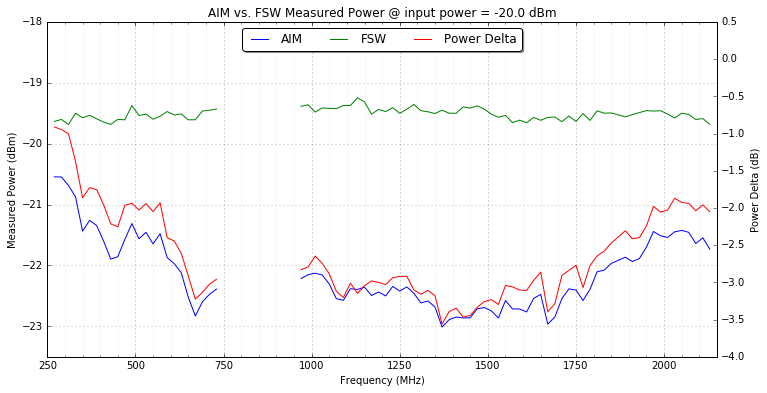

In [59]:
%matplotlib inline
# Set plot sizes
fig_size = plt.rcParams["figure.figsize"] # (6,4)
fig_size[1] = 6
fig_size[0] = 12#8

def plot_all():
    # Plot AIM and FSW power at each input power
    for i, group in df.groupby("SFU Power (dBm)"):
        ax = group.plot(x="Frequency (MHz)",
                        y="AIM Power (dBm)",
                        kind="line",
                        title="AIM vs. FSW Measured Power @ input power = "+str(i)+" dBm",
                        label="AIM"
                       )
        ax.set_ylabel("Measured Power (dBm)")
        group.plot(ax=ax,
                   x="Frequency (MHz)",
                   y="FSW Power (dBm)",
                   kind="line",
                   label="FSW",
                   sharex=False
                  )
        # Format plot
        major_ticks = np.arange(250, 2150, 250)
        minor_ticks = np.arange(250, 2150, 50)
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        # Format legend
        ylim = ax.get_ylim()
        ax.set_ylim(top=ylim[1]+1)
        temp = ax.legend(loc='upper center', 
                         bbox_to_anchor=(0.5, 1),
                         fancybox=True, 
                         shadow=True, 
                         ncol=5
                        )

def plot_power(power, delta):
    # Plot AIM Power
    ax = (df.pivot(index="Frequency (MHz)",
                   columns="SFU Power (dBm)",
                   values="AIM Power (dBm)"
                  )[power]
            .plot(label="AIM")
         )
    # Plot FSW Power
    (df.pivot(index="Frequency (MHz)",
              columns="SFU Power (dBm)",
              values="FSW Power (dBm)"
             )[power]
        .plot(ax=ax,
              label="FSW")
    )
    # Plot Delta
    if delta:
        (df.pivot(index="Frequency (MHz)",
                  columns="SFU Power (dBm)",
                  values="AIM - FSW Power Delta"
                 )[power]
           .plot(ax=ax,
                 secondary_y=True,
                 label="Power Delta"
                )
        )
        ax.right_ax.set_ylabel('Power Delta (dB)')
    # Format plot
    ax.set_title("AIM vs. FSW Measured Power @ input power = "+str(power)+" dBm")
    ax.set_ylabel("Measured Power (dBm)")
    format_frequency_plot(ax, secondary_y=delta)

# Create slider widget for power
options = df["SFU Power (dBm)"].unique()
options = options[~np.isnan(options)].tolist()
slider = widgets.SelectionSlider(
    options=options,
    value=-20,
    description="Input Power",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='50%'),
)
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plot_power, power=slider, delta=checkbox, layout=Layout(width='50%'))
hbox=widgets.HBox(w.children)
display(w)
# slider.value = -20
# checkbox.value = False
# plot_power(slider.value, checkbox.value)
# hbox

# Separate Plots for printed document
# plot_all()

## Summary

* AIM has more front-end loss in mid-frequencies

* AIM Power accuracy degrades at lower input power
    
    - MxL chip is receiving power ~10dB lower than input SFU power

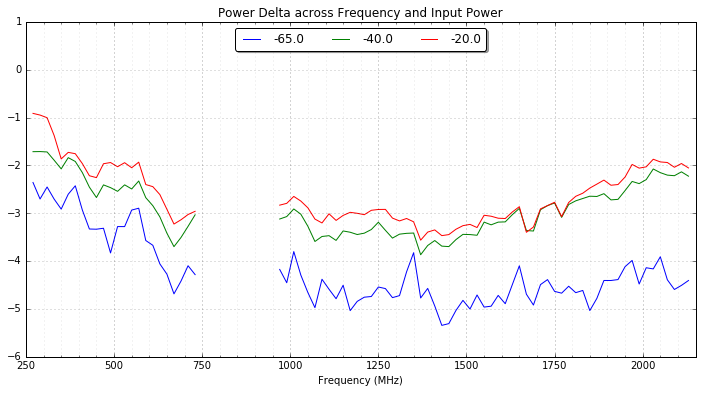

In [60]:
# For each input SFU power, plot the Power Delta across frequency
# ax = df.plot(x="Frequency (MHz)",
#         y="AIM - FSW Power Delta",
#         c="SFU Power (dBm)",
#         kind="scatter",
#         colormap="Blues",
#         title="Power Delta across Frequency and Input Power",
#         sharex=False
#         )
ax = df_delta.plot()
# Format plot
ax.set_title("Power Delta across Frequency and Input Power")
format_frequency_plot(ax, secondary_y=False)

## Comparison with InDesign

* AIM 2 vs. Agilent SpecAn power measurement

* Sweep Frequency

    - 974 - 2120 MHz

* Sweep Input Power

    - -5 to -70 dBm

In [61]:
# Read in test data from Fritz's alpha test report
fritz = pd.read_csv("data/power-accuracy/AIM2alpha-test-report.csv")
fritz["Delta"] = fritz["Delta"]*-1

# Reshape data to have columns for each input SFU power
fritz_delta = fritz.pivot(columns="Frequency (MHz)", index="SFU Power (dBm)", values="Delta")

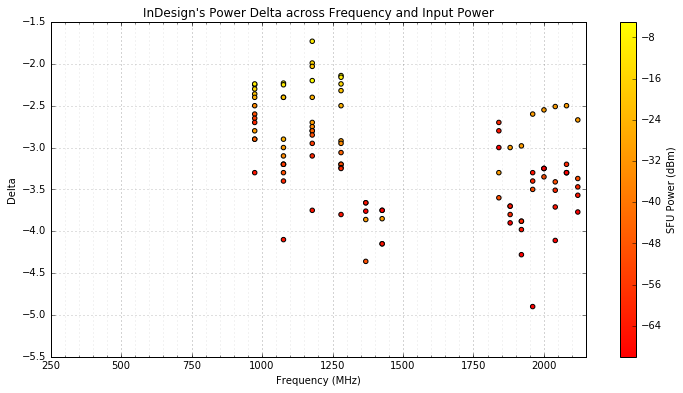

In [62]:
# For each input power, plot Fritz's Power Delta across frequency
ax = fritz.plot(x="Frequency (MHz)",
           y="Delta",
           c="SFU Power (dBm)",
           kind="scatter",
           colormap="autumn",
           title="InDesign's Power Delta across Frequency and Input Power",
           sharex=False
          )
format_frequency_plot(ax, secondary_y=False)

* For each input power, compare Fritz's Power Delta with ours

* Also plot 95% MOE on our measurements (averaged over 20 samples per data point)

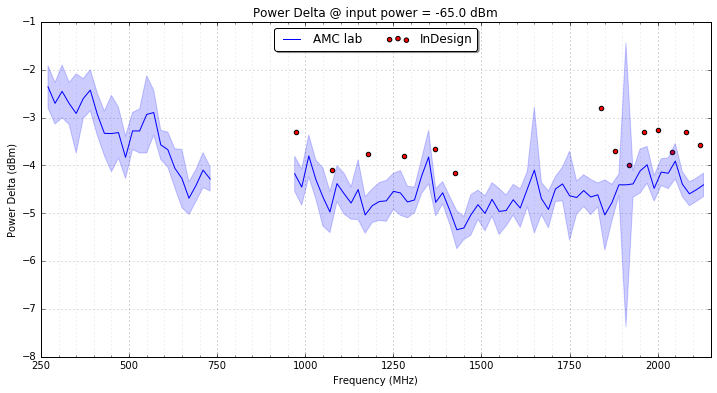

In [63]:
def plot_comparison(power):
    # For each input power, compare Fritz's Power Delta 
    # with our Power Delta across frequency
    group = df[df["SFU Power (dBm)"] == power]
    # Insert NAN samples to illustrate gap in data
    group = insert_frequency_gap(group)
    group["Frequency (MHz)"] = group["Frequency (Hz)"]/1000000
    ax = group.plot(x="Frequency (MHz)",
                    y="AIM - FSW Power Delta",
                    kind="line",
                    label="AMC lab"
                   )
    fritzgroup = fritz[fritz["SFU Power (dBm)"] == power]
    ax = fritzgroup.plot(ax=ax,
                    x="Frequency (MHz)",
                    y="Delta",
                    kind="scatter",
                    color="r",
                    label="InDesign"
                   )
    # Plot margin of error on our power measurements
    ax.fill_between(group["Frequency (MHz)"], group["AIM - FSW Power Delta"]-group["Power Error"], group["AIM - FSW Power Delta"]+group["Power Error"], color='b', alpha=0.2)
    # Format plot and legend
    ax.set_title("Power Delta @ input power = "+str(power)+" dBm")
    ax.set_ylabel("Power Delta (dBm)")
    format_frequency_plot(ax, secondary_y=False)
    temp = ax.legend(loc='upper center', 
                     bbox_to_anchor=(0.5, 1),
                     fancybox=True, 
                     shadow=True, 
                     ncol=3
                    )

def plot_all():
    for power in [-65, -40, -20]:
        plot_comparison(power)

# Create slider widget for power
options = df["SFU Power (dBm)"].unique()
options = options[~np.isnan(options)].tolist()
slider = widgets.SelectionSlider(
    options=options,
    value=-20,
    description="Input Power",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='50%'),
)
# # Display widgets
w = interactive(plot_comparison, power=slider, layout=Layout(width='50%'))
slider.value = -20
display(w)

# plot_all()

## Comparison Summary

* InDesign data is consistent with ours @ -20, -40 dBm

* not as consistent @ -65 dBm

## Playground

In [64]:
# Fully interactive dataset

# SNR Accuracy

## Test Setup
The test setup was the same as the Power Accuracy Test Setup.

![Diagram of the test setup.](img/AIM2-test-setup-diagram.png)

## Test Procedure

* Input Power = -20 dBm

* AMC Mode 12 transponder

    - DVB-S2, 8PSK, 2/3
    
    - 30 MBaud, 20% roll-off, pilots on
    
    - 6.9 dB SNR threshold

* Sweep Center Frequency

    - 270 - 730 MHz, 970 - 2130 MHz
    
    - 20 MHz steps

* Sweep Input CNR

    - 8 - 20 dB
    
    - 1 dB steps
    
* Measure AIM SNR vs. FSW Spec-An CNR

## Test Data

Plots of AIM SNR and FSW CNR across frequency at each input CNR.

In [65]:
# Read in SNR data from csv file
snr = pd.read_csv("data/snr-accuracy/Spectrum_SNR/AIM2rev0-FSW-snr-sweep_processed.csv")

# Insert NAN samples to illustrate gap in data
snr = insert_frequency_gap(snr)
snr = snr.sort_values(by="SFU SNR (dB)")

# Compute SNR Delta between FSW and AIM measurements
snr["AIM - FSW SNR Delta"] = snr["AIM SNR"] - snr["FSW_SNR(dB)"]
snr["Frequency (MHz)"] = snr["Frequency (Hz)"]/1000000

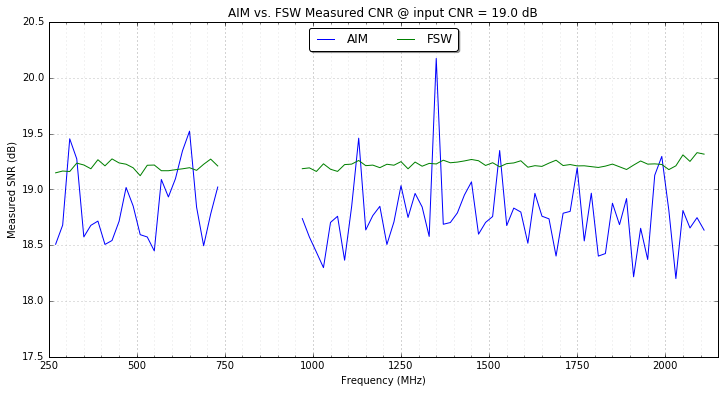

In [66]:
def plot_all():
    # Plot AIM and FSW power at each input power
    for i, group in snr.groupby("SFU SNR (dB)"):
        plot_snr(i, True)

def plot_snr(input_snr, delta):
    # Plot AIM SNR
    ax = (snr.pivot(index="Frequency (MHz)",
                   columns="SFU SNR (dB)",
                   values="AIM SNR"
                  )[input_snr]
            .plot(label="AIM")
         )
    # Plot FSW SNR
    (snr.pivot(index="Frequency (MHz)",
              columns="SFU SNR (dB)",
              values="FSW_SNR(dB)"
             )[input_snr]
        .plot(ax=ax,
              label="FSW")
    )
    # Plot Delta
    if delta:
        (snr.pivot(index="Frequency (MHz)",
                  columns="SFU SNR (dB)",
                  values="AIM - FSW SNR Delta"
                 )[input_snr]
           .plot(ax=ax,
                 secondary_y=True,
                 label="SNR Delta"
                )
        )
        ax.right_ax.set_ylabel('SNR Delta (dB)')
    # Format plot
    ax.set_title("AIM vs. FSW Measured CNR @ input CNR = "+str(input_snr)+" dB")
    ax.set_ylabel("Measured SNR (dB)")
    format_frequency_plot(ax, secondary_y=delta)
    ax.set_ylim([input_snr-1.5, input_snr+1.5])
    if delta:
        ax.right_ax.set_ylim([-1.5, 1.5])

# Create slider widget for power
options = snr["SFU SNR (dB)"].unique()
options = options[~np.isnan(options)].tolist()
slider = widgets.SelectionSlider(
    options=options,
    description="Input SNR",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='50%'),
)
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='SNR Delta',
    disabled=False,
)
# Display widgets
w = interactive(plot_snr, input_snr=slider, delta=checkbox, layout=Layout(width='50%'))
hbox=widgets.HBox(w.children)    
slider.value = 8
checkbox.value = False
display(w)

# Separate Plots for printed document
# plot_all()

## Statistics

* No noticeable trend in SNR delta across frequency


* Histograms show that SNR deltas are likely normally-distributed measurement error

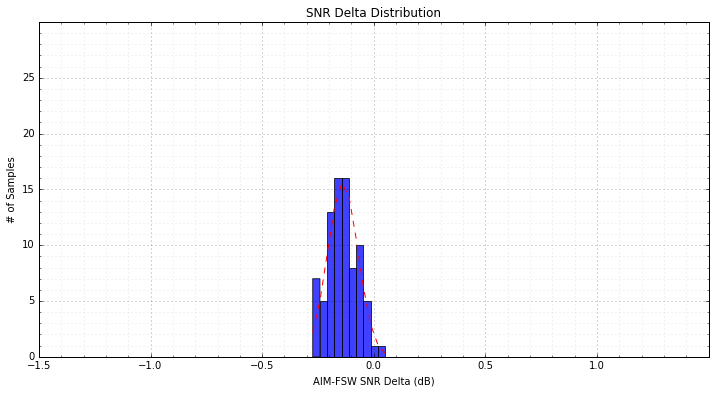

In [67]:
def plot_all():
    # Plot AIM and FSW power at each input power
    for i, group in snr.groupby("SFU SNR (dB)"):
        plot_snr(i, True)

def plot_histogram(input_snr):
    # Summarize frequency measurements in histogram for each input CNR
    group = snr[snr["SFU SNR (dB)"] == input_snr]
    n, bins, patches = plt.hist(group["AIM - FSW SNR Delta"], alpha=0.75)
    # Format histogram
    ax = plt.gca()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([0, 30])
    plt.xlabel('AIM-FSW SNR Delta (dB)')
    plt.ylabel('# of Samples')
    plt.title('SNR Delta Distribution')
    # format grid
    major_ticks = np.arange(-1.5, 1.5, 0.5)
    minor_ticks = np.arange(-1.5, 1.5, 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks = np.arange(0, 30, 5)
    minor_ticks = np.arange(0, 30, 1)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plt.grid(True)
    # Plot fitted normal distribution
    y = mlab.normpdf(bins, group["AIM - FSW SNR Delta"].mean(), group["AIM - FSW SNR Delta"].std())
    normalize = len(group["AIM - FSW SNR Delta"])*(bins[1]-bins[0])
    y_num = y*normalize
    temp = plt.plot(bins, y_num, 'r--', linewidth=1)

# Create slider widget for power
options = snr["SFU SNR (dB)"].unique()
options = options[~np.isnan(options)].tolist()
slider = widgets.SelectionSlider(
    options=options,
    description="Input SNR",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='50%'),
)

# Display widgets
w = interactive(plot_histogram, input_snr=slider, layout=Layout(width='50%'))
display(w)

# Separate Plots for printed document
# plot_all()

* the average SNR delta increases with input CNR

* the variance in SNR delta increases with input CNR

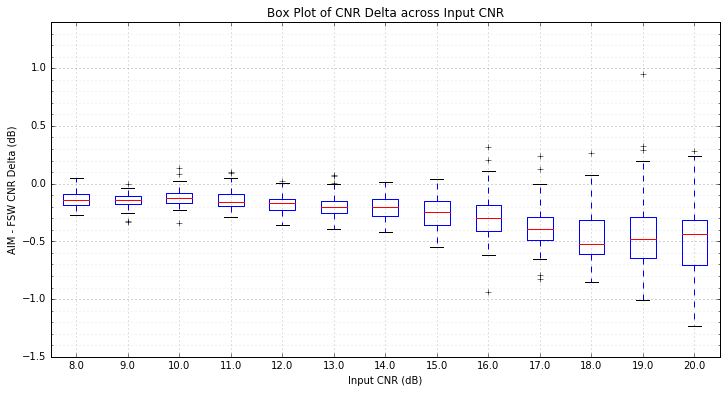

In [140]:
# Reshape table to display SNR Delta across frequency for each input CNR
snr_delta = (snr.pivot(index="Frequency (MHz)", columns="SFU SNR (dB)", values="AIM - FSW SNR Delta")
                .filter(regex='^(?!nan$).*')
            )
# Box plots across input CNR to visualize any trends in the statistics
ax = snr_delta.plot.box()
ax.set_ylabel("AIM - FSW CNR Delta (dB)")
ax.set_xlabel("Input CNR (dB)")
temp = ax.set_title("Box Plot of CNR Delta across Input CNR")
# format plot
major_ticks = np.arange(-1.5, 1.5, 0.5)
minor_ticks = np.arange(-1.5, 1.5, 0.1)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid(True)
# snr_delta.describe()

# Multiswitch Loading Scenarios

## Test Setup

![Figure 1: Diagram of the loading test setup.](img/slg-setup.png)

## Test Procedure

* Load SLG 1 w/ 12 transponders
    
    - DVB-S2, 8PSK, 2/3
    
    - 30 MBaud, 20% roll-off, Pilots On
    
    - 270 - 730 MHz band
    
    - transponder power = -15 dBm

* Load SLG 2 w/ 16 transponders
    
    - same as SLG 1, except 20 MBaud
    
    - 970 - 1430 MHz band
    
    - transponder power = -15 dBm
    
* Load SLG 3 w/ 12 transponders
    
    - same as SLG 1
    
    - 1670 - 2130 MHz band
    
    - transponder power = -26 dBm

* Measure aggregate power @ coupler output = -2 dBm

* Set desired transponder power = -2 - 31.7 = -33.7 dBm

* Set adjacent transponder power = -33.7 + 7.5 = -26.2 dBm

* Shift desired and adjacent transponder frequencies through all 40 positions

* Measure AIM power and SNR vs. FSW power and MER

## Baseline

The desired transponder has no noise or distortion.

![Figure: Example loading scenario with no noise.](img/slg-baseline.png)

### Test Data

* Plot Desired Transponder power measured by AIM and FSW across frequency

* Plot the Power Delta between the two measurements

In [69]:
# Read in SLG test data and VNA loss output
baseline = pd.read_csv(
    "data/slg-loading/baseline/frequency-sweep-vsa.csv")
AIM_loss = pd.read_csv(
    "data/insertion-loss/loading-setup/AIM-BTC.csv")
FSW_loss = pd.read_csv(
    "data/insertion-loss/loading-setup/FSW-BTC.csv")

# Compensate FSW measurements for insertion losses
AIM_loss = [find_nearest(AIM_loss, freq) for freq in baseline["Desired Frequency (Hz)"]]
FSW_loss = [find_nearest(FSW_loss, freq) for freq in baseline["Desired Frequency (Hz)"]]
FSW2AIM = [x - y for (x, y) in zip(AIM_loss, FSW_loss)]
baseline["FSW Power (dBm)"] = [FSW_Power + loss for (FSW_Power, loss) in zip(baseline["FSW Power (dBm)"], FSW2AIM)]
baseline["AIM Power (dBm)"] = [AIM_Power + 5.7 for AIM_Power in baseline["AIM Power (dBm)"]]

# Compute Power Delta between FSW and AIM measurements
baseline["AIM - FSW Power Delta"] = baseline["AIM Power (dBm)"] - baseline["FSW Power (dBm)"]
baseline["AIM - FSW SNR Delta"] = baseline["AIM SNR (dB)"] - baseline["FSW CNR (dB)"]
baseline["Frequency (MHz)"] = baseline["Desired Frequency (Hz)"]/1000000

# Compensate AIM measurements for front-end losses
dfgroup = df[df["SFU Power (dBm)"] == -40]
front_end_loss = [find_nearest(dfgroup, freq, value_col="AIM - FSW Power Delta") for freq in baseline["Desired Frequency (Hz)"]]
baseline["Calibrated Power Delta"] = [delta - loss for (delta, loss) in zip(baseline["AIM - FSW Power Delta"], front_end_loss)]
baseline["Calibrated AIM Power (dBm)"] = [power - loss for (power, loss) in zip(baseline["AIM Power (dBm)"], front_end_loss)]

# Compute Power Delta between FSW and AIM measurements
baseline["Calibrated Power Delta"] = baseline["Calibrated AIM Power (dBm)"] - baseline["FSW Power (dBm)"]

# Insert NAN samples to illustrate gap in data
baseline = insert_frequency_gap(baseline, col="Desired Frequency (Hz)", loading=True)
baseline["FSW SNR (dB)"] = baseline["FSW CNR (dB)"]

# Display Table of Power Delta across Frequency
baseline_delta = baseline[["Frequency (MHz)", "Calibrated Power Delta"]]

In [103]:
class SLGPlotter(object):
    def __init__(self, data=baseline, loadingtype="Multiswitch Loading", aftertitle=""):
        self.set_data(data)
        self.aftertitle = aftertitle
        self.loadingtype = loadingtype
        
    def set_data(self, data):
        self.data = data
        
    def basic_stats(self):
        stats = self.data["Calibrated Power Delta"].describe()
        stats_min = pd.DataFrame(stats.iloc[1:4])
        stats_max = pd.DataFrame(stats.iloc[7:])
        stats = pd.concat([stats_min, stats_max])
        return stats
    
    def plot_slg(self, meas, delta):
        if meas == "Power":
            unit = "(dBm)"
        elif meas == "SNR":
            unit = "(dB)"
        else:
            unit = ""
        # Plot Power Delta across Frequency
        ax = self.data.plot(x="Frequency (MHz)",
                      y="AIM " + meas + " " + unit,
                      kind="line",
                      label="AIM"
                      )
        self.data.plot(ax=ax,
                 x="Frequency (MHz)",
                 y="FSW " + meas + " " + unit,
                 kind="line",
                 label="FSW"
                )
        if delta:
            self.data.plot(ax=ax,
                     secondary_y=True,
                     x="Frequency (MHz)",
                     y="AIM - FSW " + meas + " Delta",
                     kind="line",
                     label=meas + " Delta (right)"
                    )
            ax.right_ax.set_ylabel(meas + ' Delta')
            ylim = ax.right_ax.get_ylim()
            temp = ax.right_ax.set_ylim(top=ylim[1], bottom=ylim[0])
        # Format plot
        ax.set_ylabel("Measured " + meas + " " + unit)
        ax.set_title("AIM v.s. FSW " + meas + " w/ " + self.loadingtype + self.aftertitle)
        ylim = ax.get_ylim()
        temp = ax.set_ylim(top=ylim[1]+5)
        format_frequency_plot(ax, secondary_y=delta)
    
    def plot_slg_compensated(self, delta):
        # Compare Power Delta across frequency with and without SLG loading
        # Use data at comparable input power = -40 dBm
        ax = self.data.plot(x="Frequency (MHz)",
                      y="AIM - FSW Power Delta",
                      kind="line",
                      label="w/ SLG"
                     )
        dfgroup = df[df["SFU Power (dBm)"] == -40]
        # Insert NAN samples to illustrate gap in data
        dfgroup = insert_frequency_gap(dfgroup)
        dfgroup["Frequency (MHz)"] = dfgroup["Frequency (Hz)"]/1000000
        dfgroup.plot(ax=ax,
                     x="Frequency (MHz)",
                     y="AIM - FSW Power Delta",
                     kind="line",
                     label="w/o SLG"
                    )
        if delta:
            # Compensate SLG Power Delta for Front-End losses
            # characterized by power accuracy data at -40 dBm
            front_end_loss = [find_nearest(dfgroup, freq, value_col="AIM - FSW Power Delta") for freq in self.data["Desired Frequency (Hz)"]]
            self.data["Calibrated Power Delta"] = [delta - loss for (delta, loss) in zip(self.data["AIM - FSW Power Delta"], front_end_loss)]

            # Scatter plot of the Calibrated Power Delta
            self.data.plot(ax=ax,
                     x="Frequency (MHz)",
                     y="Calibrated Power Delta",
                     kind="line",
                     title='AIM - FSW Power Delta'
                     )
        # format plot
        ax.set_title("Compare Power Delta w/ and w/o SLG Loading" + self.aftertitle)
        ax.set_ylabel("Power Delta (dBm)")
        ax.set_ylim([-6,6])
        format_frequency_plot(ax, secondary_y=False)

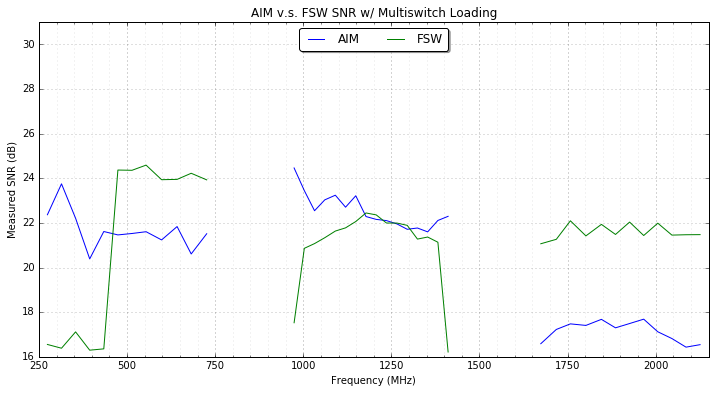

In [104]:
plotter = SLGPlotter(data=baseline)
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

### Compensate for Front-End Losses

* Consider transponder Power Delta w/o SLG loading @ -40 dBm as a baseline

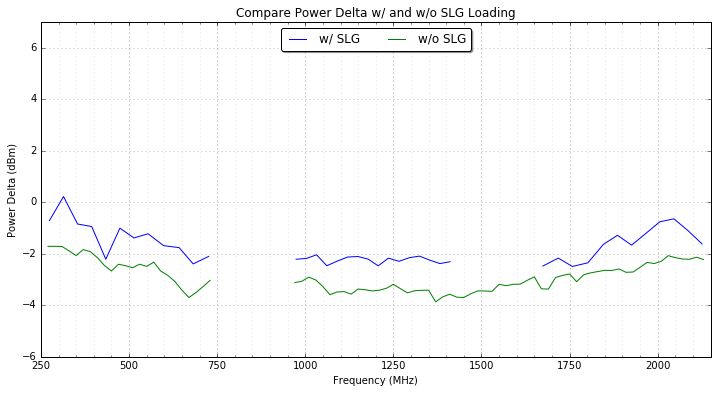

In [105]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

### Summary
* For same input power, AIM 2 measures a higher power w/ loading vs. w/o loading.

* FSW seems unstable for some MER measurements.

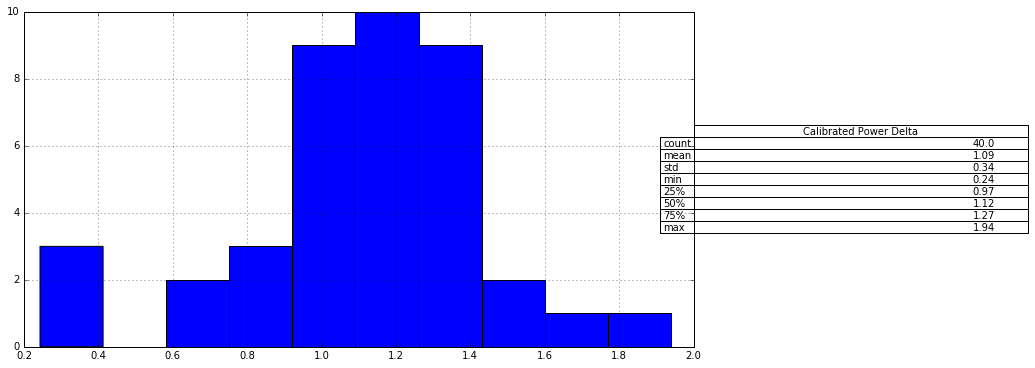

In [106]:
# Compute simple statistics on the Calibrated Power Delta
fig, ax = plt.subplots(1, 1)
table(ax, 
      np.round(baseline["Calibrated Power Delta"].describe(), 2),
      loc='right',
      colWidths=[0.5, 0.2, 0.2]
     )

# Histogram of Calibrated Power Deltas
baseline["Calibrated Power Delta"].hist(ax=ax)

## AWGN + Phase Noise
The desired transponder has 15 dB AWGN and Phase Noise.

![Figure: Example loading scenario with AWGN and Phase Noise.](img/slg-noise.png)

In [107]:
# Read in SLG loading + AWGN + Phase Noise test data
noise = pd.read_csv(
    "data/slg-loading/Noise_PN/frequency-sweep-vsa.csv")

# Compensate AIM and FSW measurements for insertion losses
noise["FSW Power (dBm)"] = [FSW_Power + loss for (FSW_Power, loss) in zip(noise["FSW Power (dBm)"], FSW2AIM)]
noise["AIM Power (dBm)"] = [AIM_Power + 5.7 for AIM_Power in noise["AIM Power (dBm)"]]
noise["AIM - FSW Power Delta"] = noise["AIM Power (dBm)"] - noise["FSW Power (dBm)"]
noise["AIM - FSW SNR Delta"] = noise["AIM SNR (dB)"] - noise["FSW CNR (dB)"]
noise["FSW SNR (dB)"] = noise["FSW CNR (dB)"]

# Compensate AIM measurements for front-end losses
noise["Calibrated AIM Power (dBm)"] = [power - loss for (power, loss) in zip(noise["AIM Power (dBm)"], front_end_loss)]

# Insert NAN samples to illustrate gap in data
noise = insert_frequency_gap(noise, col="Desired Frequency (Hz)", loading=True)
noise["FSW SNR (dB)"] = noise["FSW CNR (dB)"]

# Compute Power Delta between FSW and AIM measurements
noise["Calibrated Power Delta"] = noise["Calibrated AIM Power (dBm)"] - noise["FSW Power (dBm)"]
noise["Frequency (MHz)"] = noise["Desired Frequency (Hz)"]/1000000

# Display Table of Power Delta across Frequency
noise_delta = noise[["Frequency (MHz)", "Calibrated Power Delta"]]

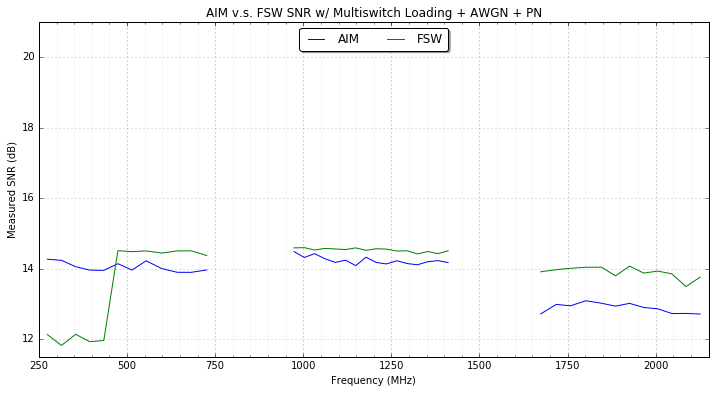

In [108]:
plotter = SLGPlotter(data=noise, aftertitle=" + AWGN + PN")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

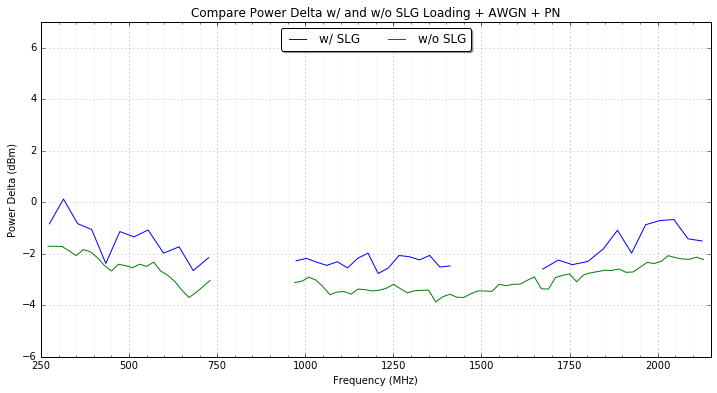

In [109]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

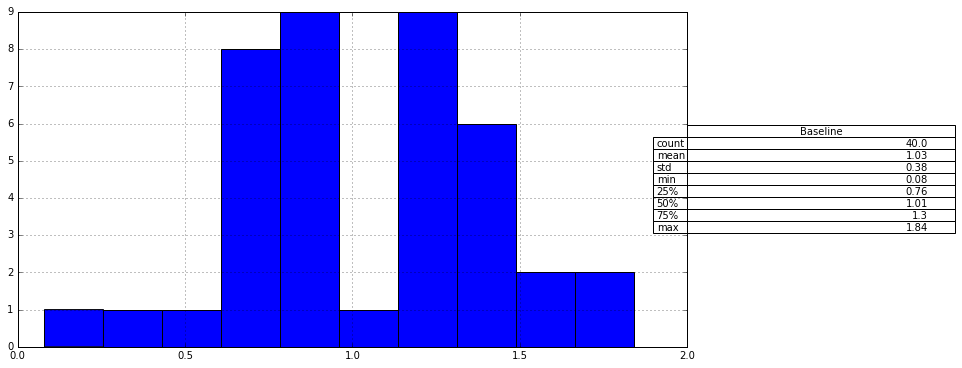

In [110]:
# Compare statistics on the Calibrated Power Delta w/ and w/o AWGN + Phase Noise
noise_stats = pd.DataFrame(noise["Calibrated Power Delta"].describe())
noise_stats.rename(columns={'Calibrated Power Delta': 'Baseline'}, inplace=True)
noise_stats.rename(columns={'Calibrated Power Delta': 'AWGN + Phase Noise'}, inplace=True)

# Plot statistics along-side histogram
fig, ax = plt.subplots(1, 1)
table(ax, 
      np.round(noise_stats, 2),
      loc='right',
      colWidths=[0.4, 0.4, 0.4]
     )

# Histogram of Calibrated Power Deltas
noise["Calibrated Power Delta"].hist(ax=ax)

## Distortion

The desired transponder has 15 dB AWGN, Phase Noise, and Group Delay Distortion.

![Figure: Example loading scenario with group delay distortion.](img/slg-distortion.png)

In [111]:
# Read in SLG loading + AWGN + Phase Noise test data
distortion = pd.read_csv(
    "data/slg-loading/Distortion/frequency-sweep-vsa_trial2.csv")

# Compensate AIM and FSW measurements for insertion losses
distortion["FSW Power (dBm)"] = [FSW_Power + loss for (FSW_Power, loss) in zip(distortion["FSW Power (dBm)"], FSW2AIM)]
distortion["AIM Power (dBm)"] = [AIM_Power + 5.7 for AIM_Power in distortion["AIM Power (dBm)"]]
distortion["AIM - FSW Power Delta"] = distortion["AIM Power (dBm)"] - distortion["FSW Power (dBm)"]
distortion["AIM - FSW SNR Delta"] = distortion["AIM SNR (dB)"] - distortion["FSW CNR (dB)"]
distortion["FSW SNR (dB)"] = distortion["FSW CNR (dB)"]

# Compensate AIM measurements for front-end losses
distortion["Calibrated AIM Power (dBm)"] = [power - loss for (power, loss) in zip(distortion["AIM Power (dBm)"], front_end_loss)]

# Insert NAN samples to illustrate gap in data
distortion = insert_frequency_gap(distortion, col="Desired Frequency (Hz)", loading=True)
distortion["FSW SNR (dB)"] = distortion["FSW CNR (dB)"]

# Compute Power Delta between FSW and AIM measurements
distortion["Calibrated Power Delta"] = distortion["Calibrated AIM Power (dBm)"] - distortion["FSW Power (dBm)"]
distortion["Frequency (MHz)"] = distortion["Desired Frequency (Hz)"]/1000000

# Display Table of Power Delta across Frequency
distortion_delta = distortion[["Frequency (MHz)", "Calibrated Power Delta"]]

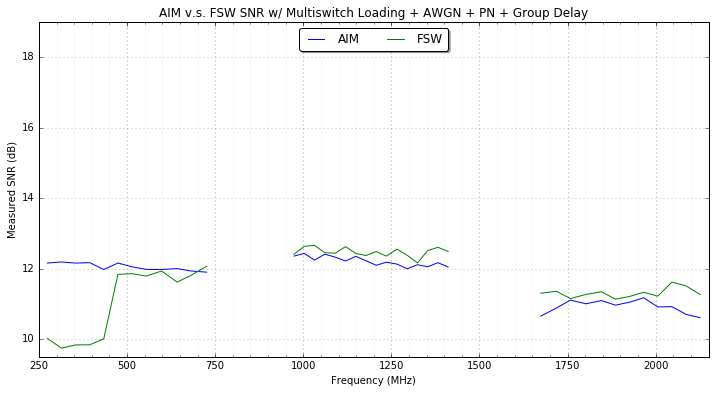

In [112]:
plotter = SLGPlotter(data=distortion, aftertitle=" + AWGN + PN + Group Delay")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

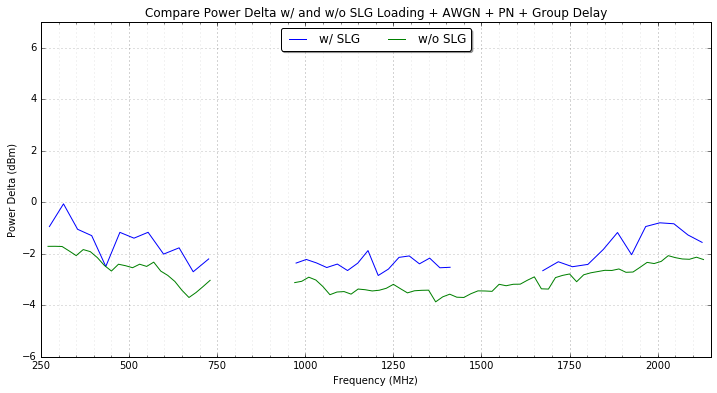

In [113]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

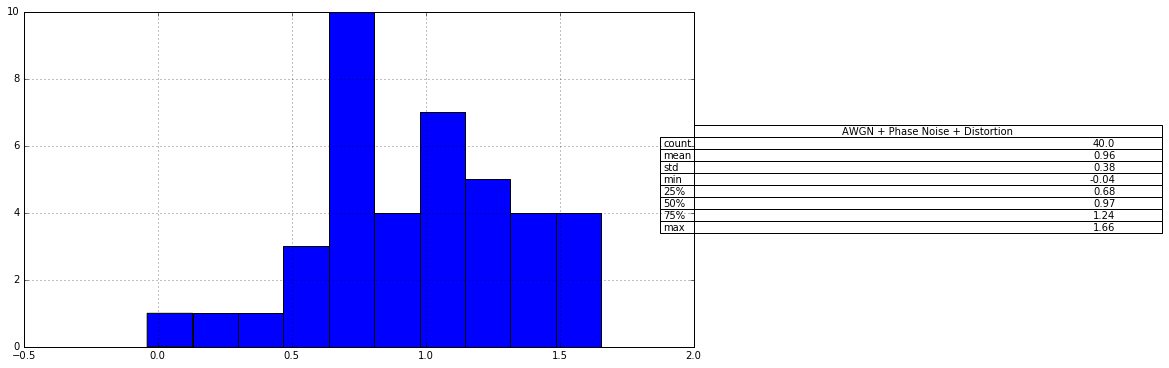

In [114]:
# Compare statistics on the Calibrated Power Delta w/ and w/o AWGN + Phase Noise
distortion_stats = pd.DataFrame(distortion["Calibrated Power Delta"].describe())
distortion_stats.rename(columns={'Calibrated Power Delta': 'AWGN + Phase Noise + Distortion'}, inplace=True)

# Plot statistics along-side histogram
fig, ax = plt.subplots(1, 1)
table(ax, 
      np.round(distortion_stats, 2),
      loc='right',
      colWidths=[0.7, 0.7, 0.7]
     )

# Histogram of Calibrated Power Deltas
distortion["Calibrated Power Delta"].hist(ax=ax)

## Summary

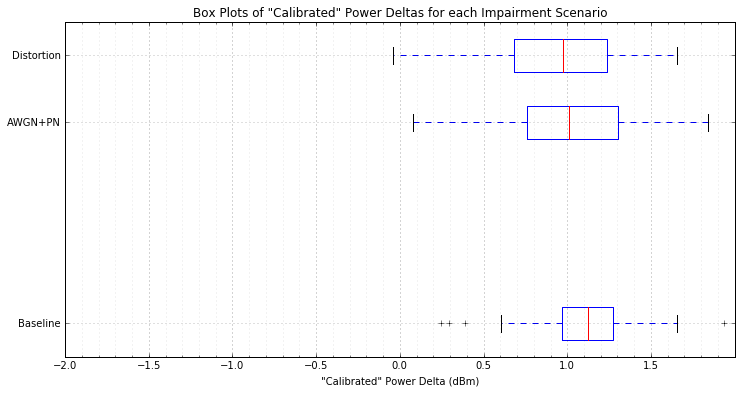

In [115]:
# Reindex each delta dataframe, and concatenate them
deltas = [baseline_delta, noise_delta, distortion_delta]
names = ["Baseline", "AWGN+PN", "Distortion"]
total_delta = pd.DataFrame()
for delta, name in zip(deltas, names):
    delta = delta[~np.isnan(delta["Calibrated Power Delta"])]
    delta = delta.set_index("Frequency (MHz)")
    delta.rename(columns={'Calibrated Power Delta': name}, inplace=True)
    if total_delta.empty:
        total_delta = delta
    else:
        total_delta = pd.concat([total_delta, delta], axis=1)
# Box plots across input CNR to visualize any trends in the statistics
ax = total_delta.plot.box(vert=False, positions=[1, 4, 5])
ax.set_xlabel('"Calibrated" Power Delta (dBm)')
temp = ax.set_title('Box Plots of "Calibrated" Power Deltas for each Impairment Scenario')
# format plot
major_ticks = np.arange(-2, 2, 0.5)
minor_ticks = np.arange(-2, 2, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid(True)

# DSWM Loading Scenarios

## Baseline

The desired transponder has no noise or distortion.

![Figure: Example loading scenario with no noise.](img/slg-baseline.png)

In [116]:
def process_dswm_data(inputfile="data/slg-loading-dswm/dswm23_slg_noiseOff.csv"):

    # Read in Multipath test data
    dswm = pd.read_csv(inputfile)

    # Compensate AIM and FSW measurements for insertion losses
    dswm["FSW Power (dBm)"] = [FSW_Power + loss for (FSW_Power, loss) in zip(dswm["FSW Power (dBm)"], FSW2AIM)]
    dswm["AIM Power (dBm)"] = [AIM_Power + 5.7 for AIM_Power in dswm["AIM Power (dBm)"]]
    dswm["AIM - FSW Power Delta"] = dswm["AIM Power (dBm)"] - dswm["FSW Power (dBm)"]
    dswm["AIM - FSW SNR Delta"] = dswm["AIM SNR (dB)"] - dswm["FSW CNR (dB)"]
    dswm["FSW SNR (dB)"] = dswm["FSW CNR (dB)"]

    # Compensate AIM measurements for front-end losses
    dswm["Calibrated AIM Power (dBm)"] = [power - loss for (power, loss) in zip(dswm["AIM Power (dBm)"], front_end_loss)]

    # Insert NAN samples to illustrate gap in data
#     dswm = insert_frequency_gap(dswm, col="Desired Frequency (Hz)", loading=True)
    dswm["FSW SNR (dB)"] = dswm["FSW CNR (dB)"]

    # Compute Power Delta between FSW and AIM measurements
    dswm["Calibrated Power Delta"] = dswm["Calibrated AIM Power (dBm)"] - dswm["FSW Power (dBm)"]
    dswm["Frequency (MHz)"] = dswm["Desired Frequency (Hz)"]/1000000

    # Display Table of Power Delta across Frequency
    dswm_delta = dswm[["Frequency (MHz)", "Calibrated Power Delta"]]
    
    return (dswm, dswm_delta)

In [117]:
(dswm_baseline, dswm_baseline_delta) = process_dswm_data(inputfile="data/slg-loading-dswm/dswm23_slg_noiseOff.csv")

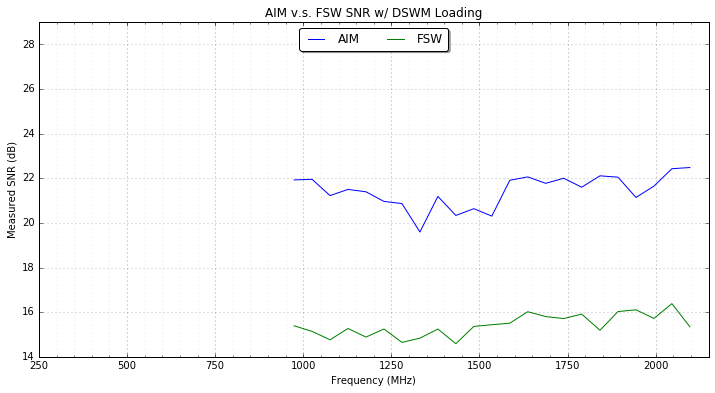

In [119]:
plotter = SLGPlotter(data=dswm_baseline, loadingtype="DSWM Loading")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

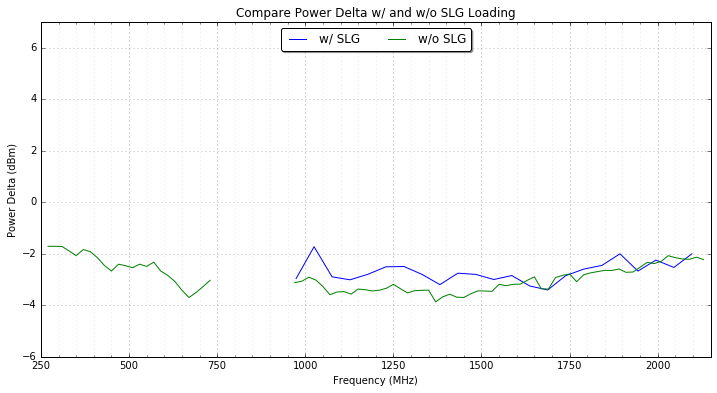

In [121]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

## AWGN + Phase Noise
The desired transponder has 15 dB AWGN and Phase Noise.

![Figure: Example loading scenario with AWGN and Phase Noise.](img/slg-noise.png)

In [122]:
(dswm_noise, dswm_noise_delta) = process_dswm_data(inputfile="data/slg-loading-dswm/dswm23_slg_noise.csv")

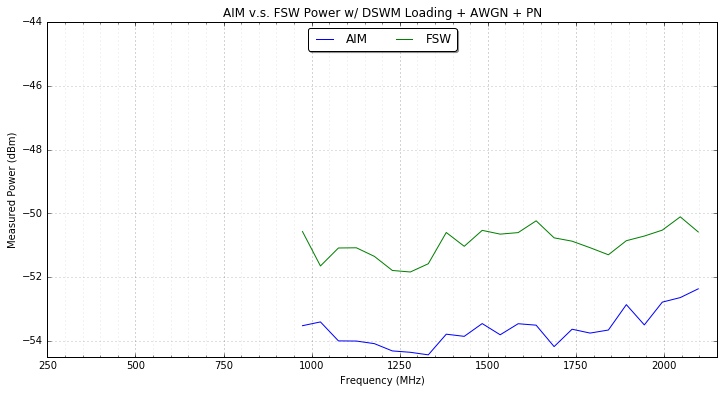

In [123]:
plotter = SLGPlotter(data=dswm_noise, loadingtype="DSWM Loading", aftertitle=" + AWGN + PN")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

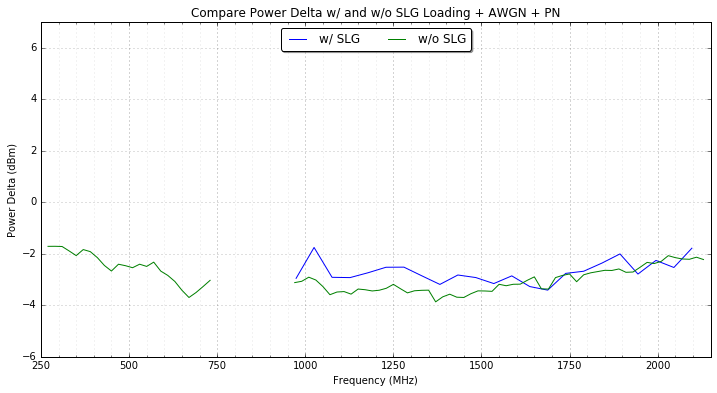

In [124]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

## Distortion

The desired transponder has 15 dB AWGN, Phase Noise, and Group Delay Distortion.

![Figure: Example loading scenario with group delay distortion.](img/slg-distortion.png)

In [125]:
(dswm_distortion, dswm_distortion_delta) = process_dswm_data(inputfile="data/slg-loading-dswm/dswm23_slg_distortionTrial2.csv")

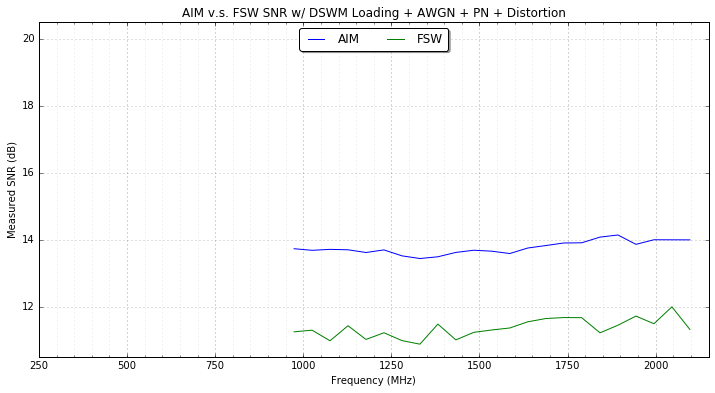

In [126]:
plotter = SLGPlotter(data=dswm_distortion, loadingtype="DSWM Loading", aftertitle=" + AWGN + PN + Distortion")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

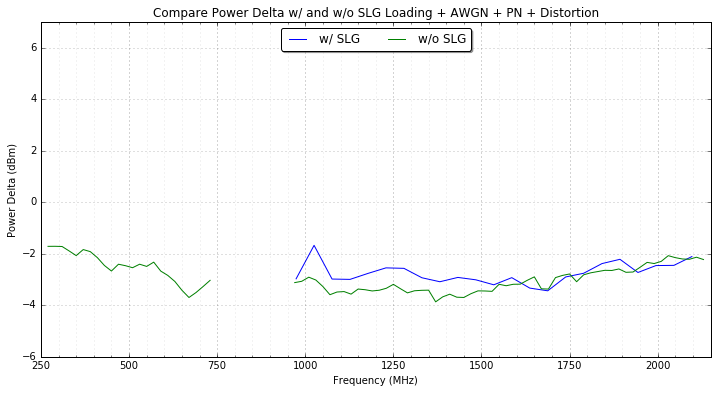

In [127]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

## Multipath

The desired transponder has 15 dB AWGN, Phase Noise, Group Delay distortion, and "worst-case" Multipath profile.

![Figure: Example loading scenario with "worst-case" multipath profile.](img/slg-multipath.png)

In [128]:
(dswm_multipath, dswm_multipath_delta) = process_dswm_data(inputfile="data/slg-loading-dswm/dswm23_slg_distortionmultipath2.csv")

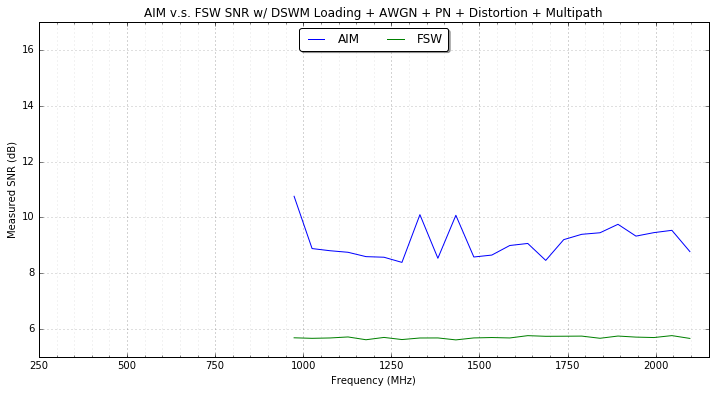

In [129]:
plotter = SLGPlotter(data=dswm_multipath, loadingtype="DSWM Loading", aftertitle=" + AWGN + PN + Distortion + Multipath")
        
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Delta',
    disabled=False
)

# Create a dropdown
dropdown = widgets.Dropdown(
    options=['Power', 'SNR'],
    value='Power',
    description='Measure:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

# Display widgets
w = interactive(plotter.plot_slg, meas=dropdown, delta=checkbox)
hbox=widgets.HBox(w.children)
display(w)

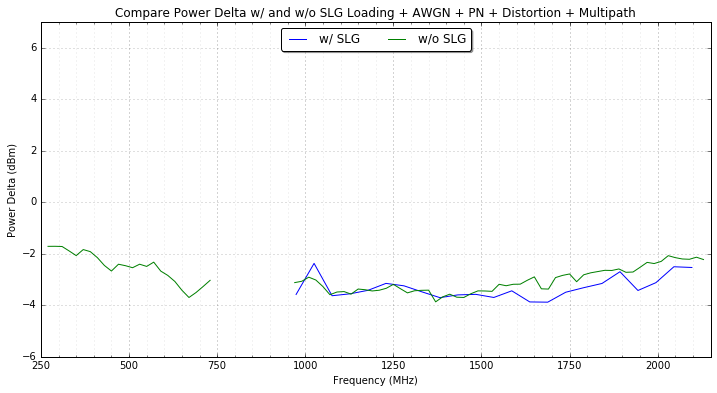

In [130]:
# Create checkbox widget for power delta
checkbox = widgets.Checkbox(
    value=False,
    description='Power Delta',
    disabled=False
)
# Display widgets
w = interactive(plotter.plot_slg_compensated, delta=checkbox, layout=Layout(width='50%'))
display(w)

## Summary

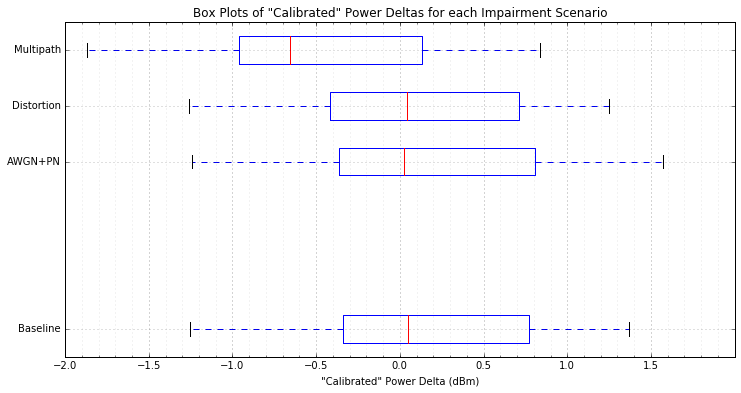

In [132]:
# Reindex each delta dataframe, and concatenate them
deltas = [dswm_baseline_delta, dswm_noise_delta, dswm_distortion_delta, dswm_multipath_delta]
names = ["Baseline", "AWGN+PN", "Distortion", "Multipath"]
total_delta = pd.DataFrame()
for delta, name in zip(deltas, names):
    delta = delta.set_index("Frequency (MHz)")
    delta.rename(columns={'Calibrated Power Delta': name}, inplace=True)
    if total_delta.empty:
        total_delta = delta
    else:
        total_delta = pd.concat([total_delta, delta], axis=1)
# Box plots across input CNR to visualize any trends in the statistics
ax = total_delta.plot.box(vert=False, positions=[1, 4, 5, 6])
ax.set_xlabel('"Calibrated" Power Delta (dBm)')
temp = ax.set_title('Box Plots of "Calibrated" Power Deltas for each Impairment Scenario')
# format plot
major_ticks = np.arange(-2, 2, 0.5)
minor_ticks = np.arange(-2, 2, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid(True)

# Frequency Sensitivity

## Test Setup

![Figure 1: Diagram of the frequency sensitivity setup.](img/sensitivity-setup.png)

## Test Procedure

* AMC Mode 12 transponder

    - DVB-S2, 8PSK, 2/3
    
    - 30 MBaud, 20% roll-off, pilots on
    
    - 6.9 dB SNR threshold
    
* No noise or distortion

* Sweep Center Frequency:

    - 270-730, 970-2130 MHz
    
    - 20MHz step

* Start Input Power = -82 dBm

* Measure BER for 5 sec.

    - if BERT not locked or BER > 0: 
    
        + Increment input power by 0.1 dB
    
    - if BERT locked and BER = 0: 
    
        + Measure BER for 60 sec.
    
            * if BER > 0: Increment input power by 0.1 dB
        
            * if BER = 0: Measure Power, SNR, BER stats            

## Test Data

In [133]:
# Read in Sensitivity sweep data
sensitivity = pd.read_csv(
    "data/FrequencySensitivity/frequency-sensitivity_processed.csv")

# Insert NAN samples to illustrate gap in data
sensitivity = insert_frequency_gap(sensitivity, col="Desired Frequency (Hz)")
sensitivity["Frequency (MHz)"] = sensitivity["Desired Frequency (Hz)"]/1000000

In [134]:
def plot_sensitivity(list_of_args):
    # Multiple selection widget returns a list of objects
    ax = None
    list_of_args = list(list_of_args)
    list_of_args.sort(key=lambda args: args["secondary_y"])
    for args in list_of_args:
        label = args["label"]
        col = args["col"]
        secondary_y = args["secondary_y"]
        if len(list_of_args) == 1:
            secondary_y = False
        # Frequency plot
        ax2 = sensitivity.plot(ax=ax,
                              x="Frequency (MHz)",
                              y=col,
                              kind="line",
                              label=label,
                              secondary_y=secondary_y,
                              )
        # Format plot
        if secondary_y:
            ax.right_ax.set_ylabel(col)
#             ylim = ax.right_ax.get_ylim()
#             temp = ax.right_ax.set_ylim(top=ylim[1], bottom=ylim[0])
        else:
            ax = ax2
            ax.set_ylabel(col)
        ax.set_title("Frequency Sensitivity")
        format_frequency_plot(ax, secondary_y=secondary_y)

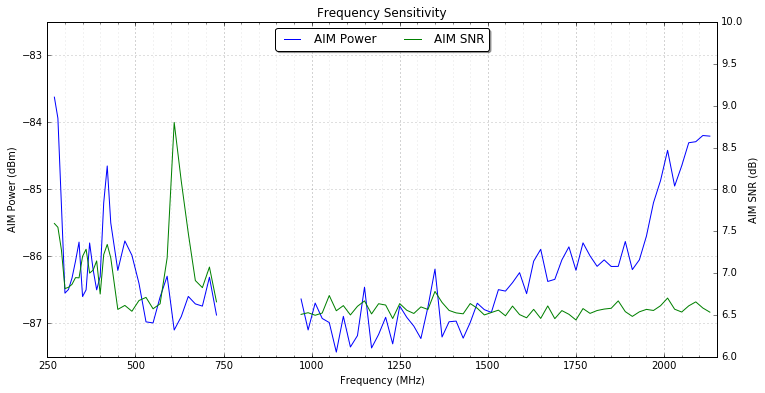

In [135]:
# Create Multiple Selection widget
selection = widgets.SelectMultiple(
    options={'BTC Power': {"label": "BTC Power",
                           "col": "BTC Power (dBm)",
                           "secondary_y": False
                           },
             'AIM Power': {"label": "AIM Power",
                           "col": "AIM Power (dBm)",
                           "secondary_y": False
                           },
             'AIM SNR': {"label": "AIM SNR",
                           "col": "AIM SNR (dB)",
                           "secondary_y": True
                           }
            },
    description='Measure:',
    disabled=False
)

# Display widgets
w = interactive(plot_sensitivity, list_of_args=selection, layout=Layout(width='50%'))
display(w)

# Scrambling Code Sweep

## Test Setup

![Figure 1: Diagram of the frequency sensitivity setup.](img/sensitivity-setup.png)

## Test Procedure

* AMC Mode 12 transponder

    - DVB-S2, 8PSK, 2/3
    
    - 20 MBaud, 20% roll-off, pilots on
    
* Input Power = -40 dBm
    
* 10 dB AWGN + Phase Noise

* Group Delay Distortion

* 5 MHz Frequency Offset

* Sweep scrambling code indices: 0 - 1015

* Sample AIM measurements for 1 sec.:

    - AIM Demod Lock, Acq. Time
    
    - AIM BERT Lock, BER
    
    - AIM Freq. Offset
    
    - AIM Power, SNR       

Test Data

In [18]:
# Read in Scrambling Code sweep data
scrambling = pd.read_csv(
    "data/scrambling-codes/scrambling_codeSweepwithImpairments_Multipath2_total.csv")
scrambling["Demod Lock"] = [1 if x==True else 0 for x in scrambling["Demod Lock"]]
scrambling["Bert Lock"] = [1 if x==True else 0 for x in scrambling["Bert Lock"]]

In [19]:
filtered = (scrambling.filter(regex='^(?!Scrambling Code Index$).*')
                      .filter(regex='^(?!timestamp$).*'))
scrambling_stats = pd.DataFrame(filtered.describe())
scrambling_stats

,Power (dBm),SNR (dB),Freq Offset (Hz),Demod Lock,Demod Acq Time (sec),Bert Lock,Bert Total Bit Count,Bert Total Bit Error,Bit Error Rate
count,1016.000000,1016.000000,1.016000e+03,1016.0,1016.0,1016.0,1.016000e+03,1016.0,1016.0
mean,-54.406152,9.866492,-4.710788e+06,1.0,0.0,1.0,3.234749e+07,0.0,0.0
std,0.076960,0.613186,1.452619e+05,0.0,0.0,0.0,1.293216e+06,0.0,0.0
min,-54.860263,9.573203,-5.305374e+06,1.0,0.0,1.0,3.031623e+07,0.0,0.0
25%,-54.403310,9.829174,-4.693164e+06,1.0,0.0,1.0,3.119289e+07,0.0,0.0
50%,-54.375983,9.847795,-4.692758e+06,1.0,0.0,1.0,3.260362e+07,0.0,0.0
75%,-54.357975,9.865861,-4.692400e+06,1.0,0.0,1.0,3.354348e+07,0.0,0.0
max,-54.210182,29.373358,-2.854773e+06,1.0,0.0,1.0,3.435543e+07,0.0,0.0


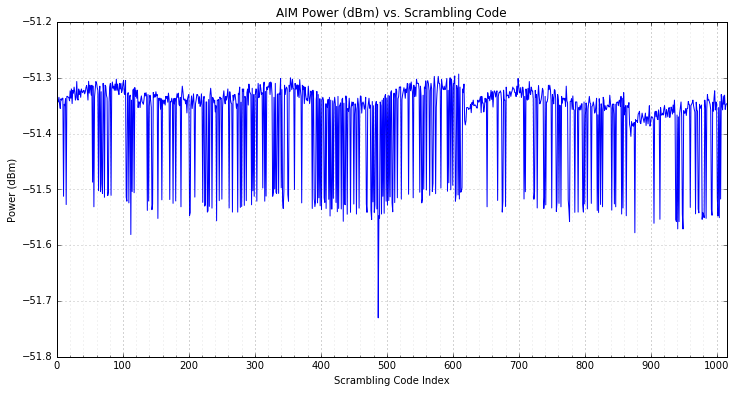

In [138]:
choose = ((scrambling_stats.loc["std"]) != 0).tolist()
columns = []
for i, col in enumerate(list(scrambling_stats)):
    if choose[i]:
        columns.append(col)

def plot_scrambling(meas):
    # Plot measurement vs. scrambling code
    ax = scrambling.plot(x="Scrambling Code Index",
                         y=meas,
                         kind="line",
                         label=meas,
                         legend=False
                        )
    # Format plot
    ax.set_xlim([0, 1015])
    plt.xlabel("Scrambling Code Index")
    plt.ylabel(meas)
    plt.title("AIM " + meas + " vs. Scrambling Code")
    # format grid
    major_ticks = np.arange(0, 1015, 100)
    minor_ticks = np.arange(0, 1015, 20)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plt.grid(True)
        
# Create a dropdown
dropdown = widgets.Dropdown(
    options=columns,
    description='Measure:',
    disabled=False
)

# Display widgets
w = interactive(plot_scrambling, meas=dropdown)
display(w)

## Test Results

* For all scrambling codes:

    - Demod locked and Bert locked

    - Demod acquisition time < 0.5 sec.